In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [7]:
from sdebridge import diffusion_bridge as db
from sdebridge import sdes
from sdebridge.utils import score_fn, fourier_coefficients, inverse_fourier
from sdebridge.data_processing import sample_ellipse, butterfly1_pts, butterfly2_pts

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [8]:
T=1.
Nt=50
dim=2
N = 4
sigma=0.05
Npt = 100

bm_sde = sdes.brownian_sde(T, Nt, dim, N, sigma)

In [9]:
ellipse_pts_target = sample_ellipse(Npt, scale=0.5)
ellipse_target = fourier_coefficients(ellipse_pts_target, N)

ellipse_pts_init = sample_ellipse(Npt, scale=0.7)
ellipse_init = fourier_coefficients(ellipse_pts_init, N)

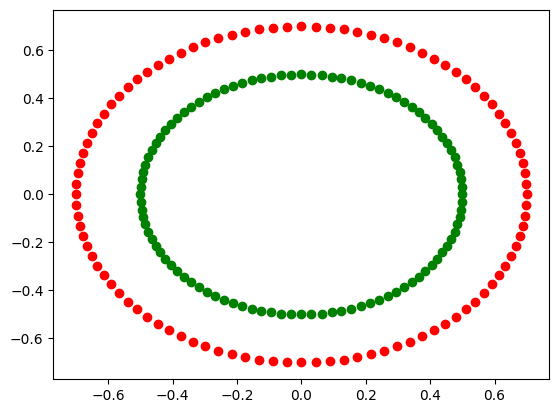

In [10]:
plt.scatter(ellipse_pts_target[:, 0], ellipse_pts_target[:, 1], c="g")
plt.scatter(ellipse_pts_init[:, 0], ellipse_pts_init[:, 1], c="r")

ellipse_init.shape=(2, 4, 2)


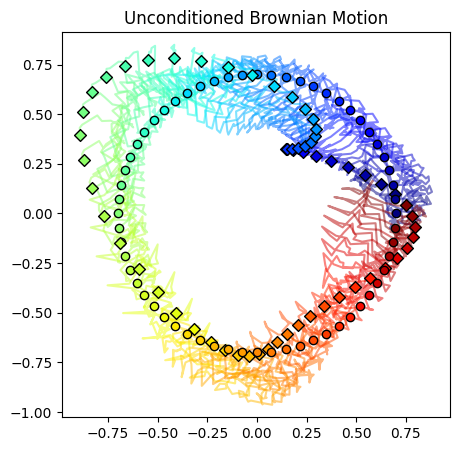

In [16]:
from sdebridge.plotting import plot_single_trajectory

key = jax.random.PRNGKey(2)
print(f"{ellipse_init.shape=}")
forward_trajs = sdes.simulate_traj(bm_sde, ellipse_init, 2, key)

forward_traj_coeffs = forward_trajs[0]
Npt = 60
forward_traj = inverse_fourier(forward_traj_coeffs, Npt)
traj = forward_traj.reshape((-1, Npt*dim))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")


In [17]:
trace_bm_sde = sdes.trace_brownian_sde(T, Nt, dim, N, alpha=0.1, power=2)

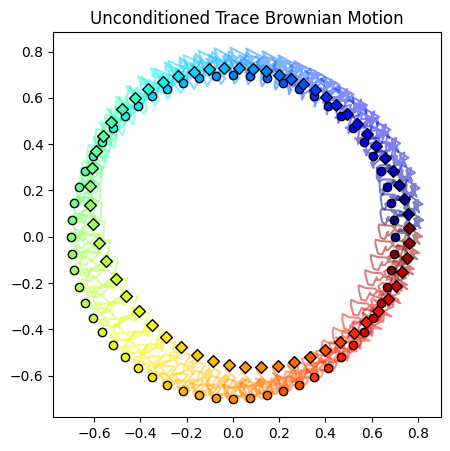

In [18]:
key = jax.random.PRNGKey(2)
forward_trajs_trace = sdes.simulate_traj(trace_bm_sde, ellipse_init, 2, key)

forward_trace_coeffs = forward_trajs_trace[0]
forward_trace = inverse_fourier(forward_trace_coeffs, Npt)
traj = forward_trace.reshape((-1, Npt*dim))
plot_single_trajectory(traj, "Unconditioned Trace Brownian Motion")

In [19]:
from sdebridge.networks.score_unet import ScoreUNet

neural_net = ScoreUNet

network = {
    "output_dim": bm_sde.dim*bm_sde.n_bases*2,
    "time_embedding_dim": 32,
    "init_embedding_dim": 32,
    "act_fn": "silu",
    "encoder_layer_dims": [32, 16, 8],
    "decoder_layer_dims": [8, 16, 32],
    "batchnorm": True,
}

training = {
    "batch_size": 100,
    "load_size": 5000,
    "num_epochs": 100,
    "learning_rate": 2e-3,
    "warmup_steps": 0,
}

def target_sampler(key, num_batches):
    initial_vals = jnp.tile(ellipse_init, reps=(num_batches, 1, 1, 1))
    return initial_vals

train_key = jax.random.split(key, 2)[0]
score_p_state = db.learn_p_score(bm_sde, target_sampler, train_key, aux_dim=2, **training, net=neural_net, network_params=network)

Training: 100%|██████████| 100/100 [01:38<00:00,  1.01epoch/s, Epoch=100, loss=355.5173]


In [20]:
reverse_sde = sdes.reverse(bm_sde, score_fn(score_p_state))
backward_coeffs = sdes.simulate_traj(reverse_sde, ellipse_target, 2, key)

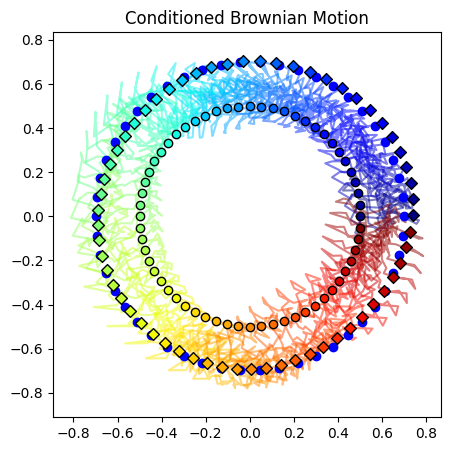

In [21]:
backward_traj = inverse_fourier(backward_coeffs[0], Npt)
traj = backward_traj.reshape((-1, Npt*dim))
plot_single_trajectory(traj, "Conditioned Brownian Motion")
target=ellipse_init
target_plt = inverse_fourier(target, 50)
plt.scatter(target_plt[:, 0], target_plt[:, 1], c="b")

(2, 50, 2, 4, 2)


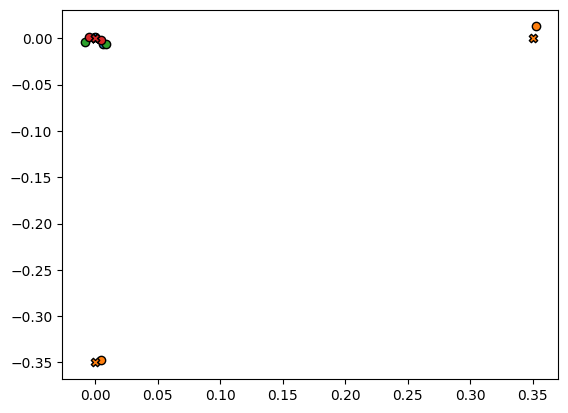

In [22]:
# plot target coefficients vs backward trajectory last coefficients

plt_backward_coeffs = backward_coeffs[0]
print(backward_coeffs.shape)

for i, coeff in enumerate(range(N)):
    plt.scatter(plt_backward_coeffs[-1, 0, coeff, 0], plt_backward_coeffs[-1, 0, coeff, 1], color=f"C{i}", edgecolors="k")
    plt.scatter(plt_backward_coeffs[-1, 1, coeff, 0], plt_backward_coeffs[-1, 1, coeff, 1], color=f"C{i}", edgecolors="k")
    # plt.scatter(plt_backward_coeffs[0, 0, coeff, 0], plt_backward_coeffs[0, 0, coeff, 1], color=f"C{i}", marker="P", edgecolors="k")
    # plt.scatter(plt_backward_coeffs[0, 1, coeff, 0], plt_backward_coeffs[0, 1, coeff, 1], color=f"C{i}", marker="P", edgecolors="k")
    # plt.plot(plt_backward_coeffs[:, coeff, 0], plt_backward_coeffs[:, coeff, 1], color=f"C{i}")
    plt.scatter(target[0, coeff, 0], target[0, coeff, 1], color=f"C{i}", marker="X", edgecolors="k")
    plt.scatter(target[1, coeff, 0], target[1, coeff, 1], color=f"C{i}", marker="X", edgecolors="k")
